In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
import imageio
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image


In [2]:
TRAIN_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'


In [3]:
pip install --user tf_keras


In [4]:
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
NUM_EPOCHS = 2


In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_list), activation='softmax'))


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
adam = Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1)

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=90,
                                  horizontal_flip=True,
                                  vertical_flip=False)


In [9]:
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


Found 520 images belonging to 2 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE)


Found 130 images belonging to 2 classes.


In [11]:
history = model.fit(x=train_generator, epochs=NUM_EPOCHS, steps_per_epoch=15,
                    shuffle=True, validation_data=test_generator)


Epoch 1/2


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6489 - loss: 3.3531 - val_accuracy: 0.7385 - val_loss: 0.6458
Epoch 2/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.7137 - loss: 0.6035 - val_accuracy: 0.7385 - val_loss: 0.7415


In [12]:
model.save("lenet_model.h5")

In [13]:
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])



17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7803 - loss: 0.6310
Test Loss: 0.7059236168861389
Test Accuracy: 0.7384615540504456


In [14]:
test_generator.reset() 

In [16]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


In [17]:
true_classes = test_generator.classes

In [18]:
confusion = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[96  0]
 [34  0]]


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_list)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     class_1       0.74      1.00      0.85        96
     class_2       0.00      0.00      0.00        34

    accuracy                           0.74       130
   macro avg       0.37      0.50      0.42       130
weighted avg       0.55      0.74      0.63       130



C:\Users\yamun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

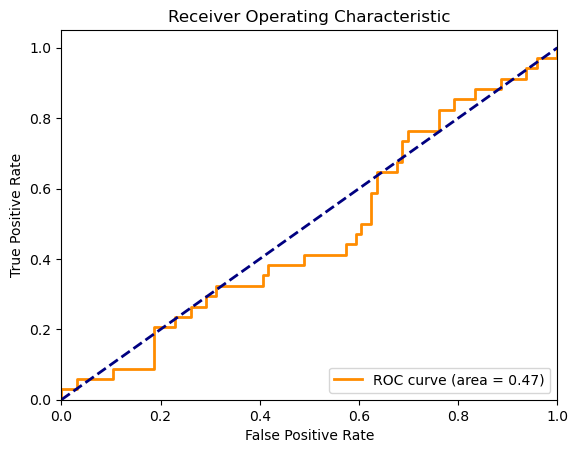

In [22]:
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])  
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
explainer = lime_image.LimeImageExplainer()


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming 2 classes for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Found 520 images belonging to 2 classes.


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

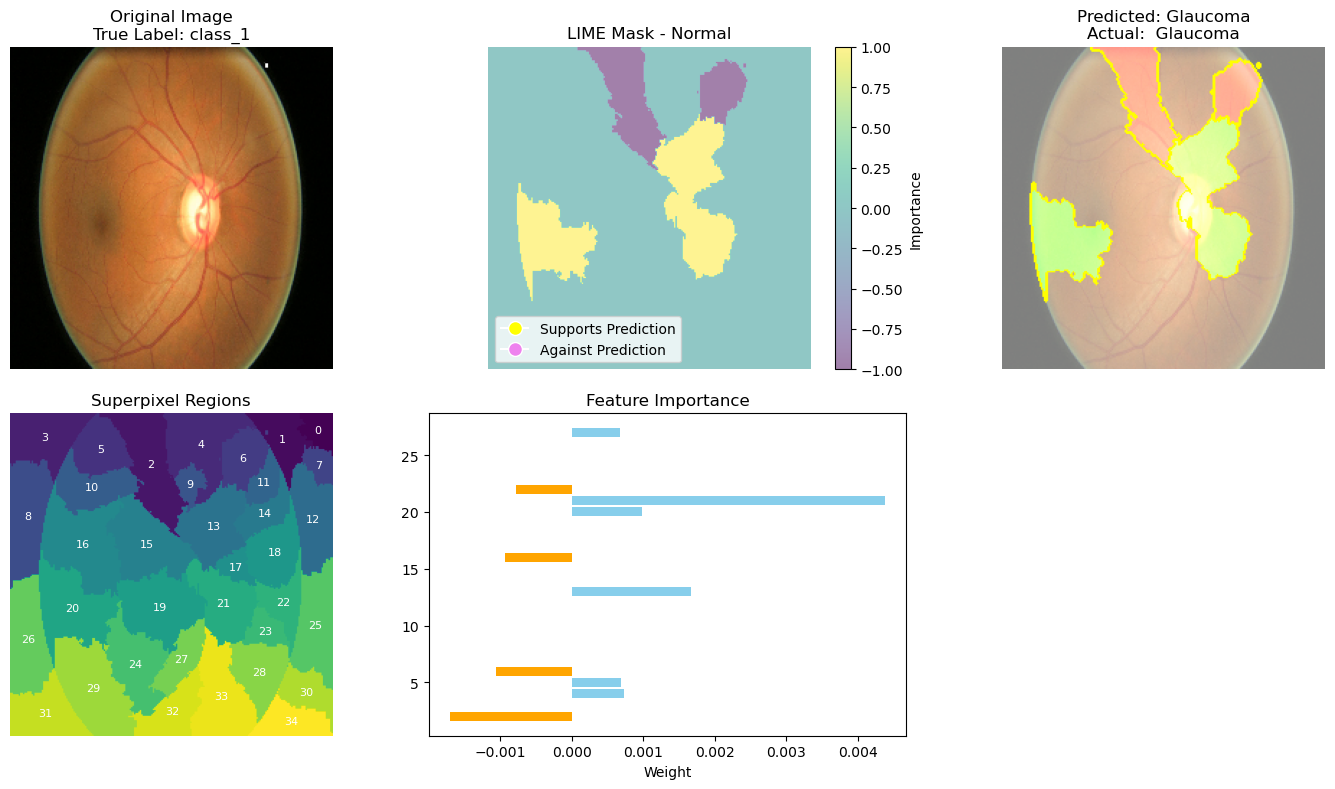

In [25]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.lines as mlines
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to generate the desired outputs for a given image index
def generate_outputs(image_index, predicted_classes, true_classes):
    # Choose a specific image from your test dataset to explain
    image = test_generator[image_index][0][0]

    # Explain the model's prediction for the chosen image
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, model.predict, top_labels=1)

    # Get the actual and predicted class labels
    actual_label = class_list[true_classes[image_index]]
    predicted_label = class_list[predicted_classes[image_index]]

    # Display the LIME mask with color representation and labels
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

    plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title(f"Original Image\nTrue Label: {actual_label}")
    plt.axis('off')

    # LIME Mask - Glaucoma
    plt.subplot(2, 3, 2)
    cmap = 'viridis'
    supports_prediction_color = 'yellow'
    against_prediction_color = 'violet'

    # Choose appropriate labels based on the model predictions
    prediction_label = 'Glaucoma' if predicted_classes[image_index] == 0 else 'Normal'

    mask_image = plt.imshow(mask, cmap=cmap, alpha=0.5)
    plt.title("LIME Mask - {}".format(prediction_label))
    colorbar = plt.colorbar(mask_image)
    colorbar.set_label('Importance')

    # Add legend to the mask image
    legend_elements = [mlines.Line2D([0], [0], marker='o', color='w', label='Supports Prediction', markerfacecolor=supports_prediction_color, markersize=10),
                       mlines.Line2D([0], [0], marker='o', color='w', label='Against Prediction', markerfacecolor=against_prediction_color, markersize=10)]
    plt.legend(handles=legend_elements, loc='lower left')
    plt.axis('off')

    
    # Predicted - Glaucoma, Ground Truth - Glaucoma
    plt.subplot(2, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Predicted: {'Glaucoma' if predicted_classes[image_index] == 1 else ' Glaucoma'}\nActual: {'Glaucoma' if actual_label == 1 else ' Glaucoma'}")
    plt.axis('off')



    # Display the superpixel regions with numbers
    superpixel_regions = explanation.segments
    plt.subplot(2, 3, 4)
    plt.imshow(superpixel_regions, cmap='viridis')

    # Add numbers inside each superpixel
    for i in range(superpixel_regions.max() + 1):
        y, x = np.where(superpixel_regions == i)
        plt.text(x.mean(), y.mean(), str(i), color='white', fontsize=8, ha='center', va='center')

    plt.title('Superpixel Regions')
    plt.axis('off')

    # Display the top 10 superpixel regions with numbers
    top_features = [str(f[0]) if isinstance(f[0], int) else f[0] for f in explanation.local_exp[explanation.top_labels[0]][:10]]  # Get top 10 features
    top_weights = [f[1] for f in explanation.local_exp[explanation.top_labels[0]][:10]]  # Get top 10 weights

    # Separate positive and negative features
    positive_features = [feature for feature, weight in zip(top_features, top_weights) if weight > 0]
    positive_weights = [weight for weight in top_weights if weight > 0]
    negative_features = [feature for feature, weight in zip(top_features, top_weights) if weight < 0]
    negative_weights = [weight for weight in top_weights if weight < 0]

    # Plot the positive and negative weights with color differentiation
    plt.subplot(2, 3, 5)

    # Plot positive weights (Normal) on the left in blue
    plt.barh(positive_features, positive_weights, color='skyblue', align='center')

    # Plot negative weights (Glaucoma) on the right in orange
    plt.barh(negative_features, negative_weights, color='orange', align='center')

    plt.xlabel('Weight')
    plt.title('Feature Importance')
    plt.tight_layout()  # Adjust layout to prevent overlapping

    # Show the plots
    plt.show()

# Assuming you have a model named 'model'
# Assuming you have a test directory with images
test_directory = 'D:\Minor Project\Fundus_Train_Val_Data\Fundus_Scanes_Sorted\Train'
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),  # Adjust based on your model's input size
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have a classification problem
    shuffle=False  # Keep the order for explanations
)

# Make predictions using the model on the test data
predictions = model.predict(test_generator)

# Extract predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Assuming you have ground truth labels
true_classes = test_generator.classes

# Choose an image index to generate outputs for
image_index_to_explain = 0
generate_outputs(image_index_to_explain, predicted_classes, true_classes)

In [1]:
pip install tensorflow_model_optimization

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

Found 130 images belonging to 2 classes.


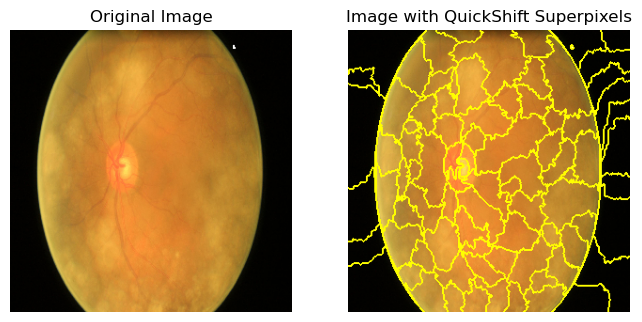

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, quickshift
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing test images
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

# Define batch size
BATCH_SIZE = 8

# Define image dimensions
HEIGHT = 300
WIDTH = 300

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),  # Use defined height and width
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you have a classification problem
    shuffle=False  # Keep the order for explanations
)

# Reset the generator to ensure consistent behavior
test_generator.reset()

# Adjust parameters for QuickShift
ratio = 1.0
kernel_size = 5
max_dist = 10

# Retrieve a batch of images from the test generator
test_batch = next(test_generator)

# Choose a specific image index from the batch
image_index_to_explain = 0  # Change this to select a different image
image = test_batch[0][image_index_to_explain]  # Retrieve the image from the batch

# Generate superpixels using QuickShift
superpixels = quickshift(image, ratio=ratio, kernel_size=kernel_size, max_dist=max_dist)

# Display the original image with superpixel boundaries
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Display the image with superpixel boundaries
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(image, superpixels))
plt.title('Image with QuickShift Superpixels')
plt.axis('off')

plt.show()


In [6]:
# Calculate the total number of superpixels
total_superpixels = len(np.unique(superpixels))

print("Total number of superpixels:", total_superpixels)


Total number of superpixels: 79878


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed, mark_boundaries
from skimage.color import rgb2gray
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directories
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'
HEIGHT = 300
WIDTH = 300

# Create an ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Get an example image path from the testing directory using flow_from_directory
example_image_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='categorical',  # Assuming you have a classification problem
    shuffle=True  # Shuffle the images
)

# Get the path to an example image
example_image_path = example_image_generator.filepaths[0]

# Load the example image
example_image = io.imread(example_image_path)

# Convert the example image to grayscale if it's a color image
if len(example_image.shape) > 2:
    example_image_gray = rgb2gray(example_image)
else:
    example_image_gray = example_image

# Adjust parameters for Compact Watershed algorithm
compactness = 0.5  # Adjust this parameter for compactness, smaller values lead to more regularly shaped superpixels
max_dist = 5  # Adjust the maximum distance between pixels, smaller values lead to more superpixels

# Apply watershed algorithm with adjusted parameters to generate superpixels
superpixels = watershed(example_image_gray, compactness=compactness, connectivity=1, watershed_line=True)

# Print total number of superpixels
total_superpixels = len(np.unique(superpixels))
print("Total number of superpixels:", total_superpixels)

# Visualize the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(example_image)
plt.title('Original Image')
plt.axis('off')

# Visualize the superpixels with boundaries
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(example_image, superpixels))
plt.title('Compact Watershed Superpixels with Boundaries')
plt.axis('off')

plt.show()


In [8]:
import numpy as np
from skimage.measure import label
from skimage.segmentation import watershed

# Assuming `gray_image` and `markers` are already defined

# Apply watershed algorithm
ws_labels = watershed(-gray_image, markers, mask=gray_image)

# Number the superpixels
labels = label(ws_labels)

# Count the unique labels, excluding the background label (0)
total_superpixels = len(np.unique(labels)) - 1

print("Total number of superpixels:", total_superpixels)


Total number of superpixels: 150


Found 130 images belonging to 2 classes.


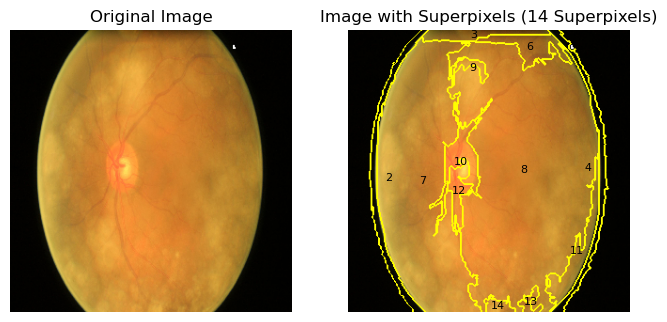

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.measure import label
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing test images
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

# Define batch size
BATCH_SIZE = 8

# Define image dimensions
HEIGHT = 300
WIDTH = 300

# Define number of desired superpixels
NUM_SUPERPIXELS = 300  # Adjusted to 300

# Define scale parameter for Felzenszwalb segmentation
SCALE = 100  # Adjust as needed

# Define sigma parameter for Felzenszwalb segmentation
SIGMA = 0.8  # Adjust as needed

def generate_superpixels(image, num_superpixels):
    # Perform Felzenszwalb segmentation
    segments_fz = felzenszwalb(image, scale=SCALE, sigma=SIGMA, min_size=num_superpixels)
    # Number the superpixels
    labels = label(segments_fz)
    return labels

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),  # Use defined height and width
    batch_size=BATCH_SIZE,
    class_mode=None,  # No need for labels in this case
    shuffle=False  # Keep the order for explanations
)

# Reset the generator to ensure consistent behavior
test_generator.reset()

# Retrieve a batch of images from the test generator
test_batch = next(test_generator)

# Choose a specific image index from the batch
image_index_to_process = 0  # Change this to select a different image
image = test_batch[image_index_to_process]  # Retrieve the image from the batch

# Generate superpixels for the entire image
superpixel_labels = generate_superpixels(image, NUM_SUPERPIXELS)

# Number the superpixels
superpixel_numbers = np.unique(superpixel_labels)
num_superpixels = len(superpixel_numbers)

# Display the original image with superpixel boundaries
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Display the image with superpixel boundaries and numbers
plt.subplot(1, 2, 2)
superpixel_image = mark_boundaries(image, superpixel_labels)
for idx, num in enumerate(superpixel_numbers, start=1):
    if num == 0:
        continue  # Skip background label
    label_mask = superpixel_labels == num
    label_center = np.mean(np.argwhere(label_mask), axis=0)
    # Set text color to black (0, 0, 0) or white (1, 1, 1) depending on preference
    text_color = (0, 0, 0)  # Black color
    plt.text(label_center[1], label_center[0], str(idx), color=text_color, fontsize=8, ha='center', va='center')
plt.imshow(superpixel_image)
plt.title(f'Image with Superpixels ({num_superpixels} Superpixels)')
plt.axis('off')

plt.show()


Found 130 images belonging to 2 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

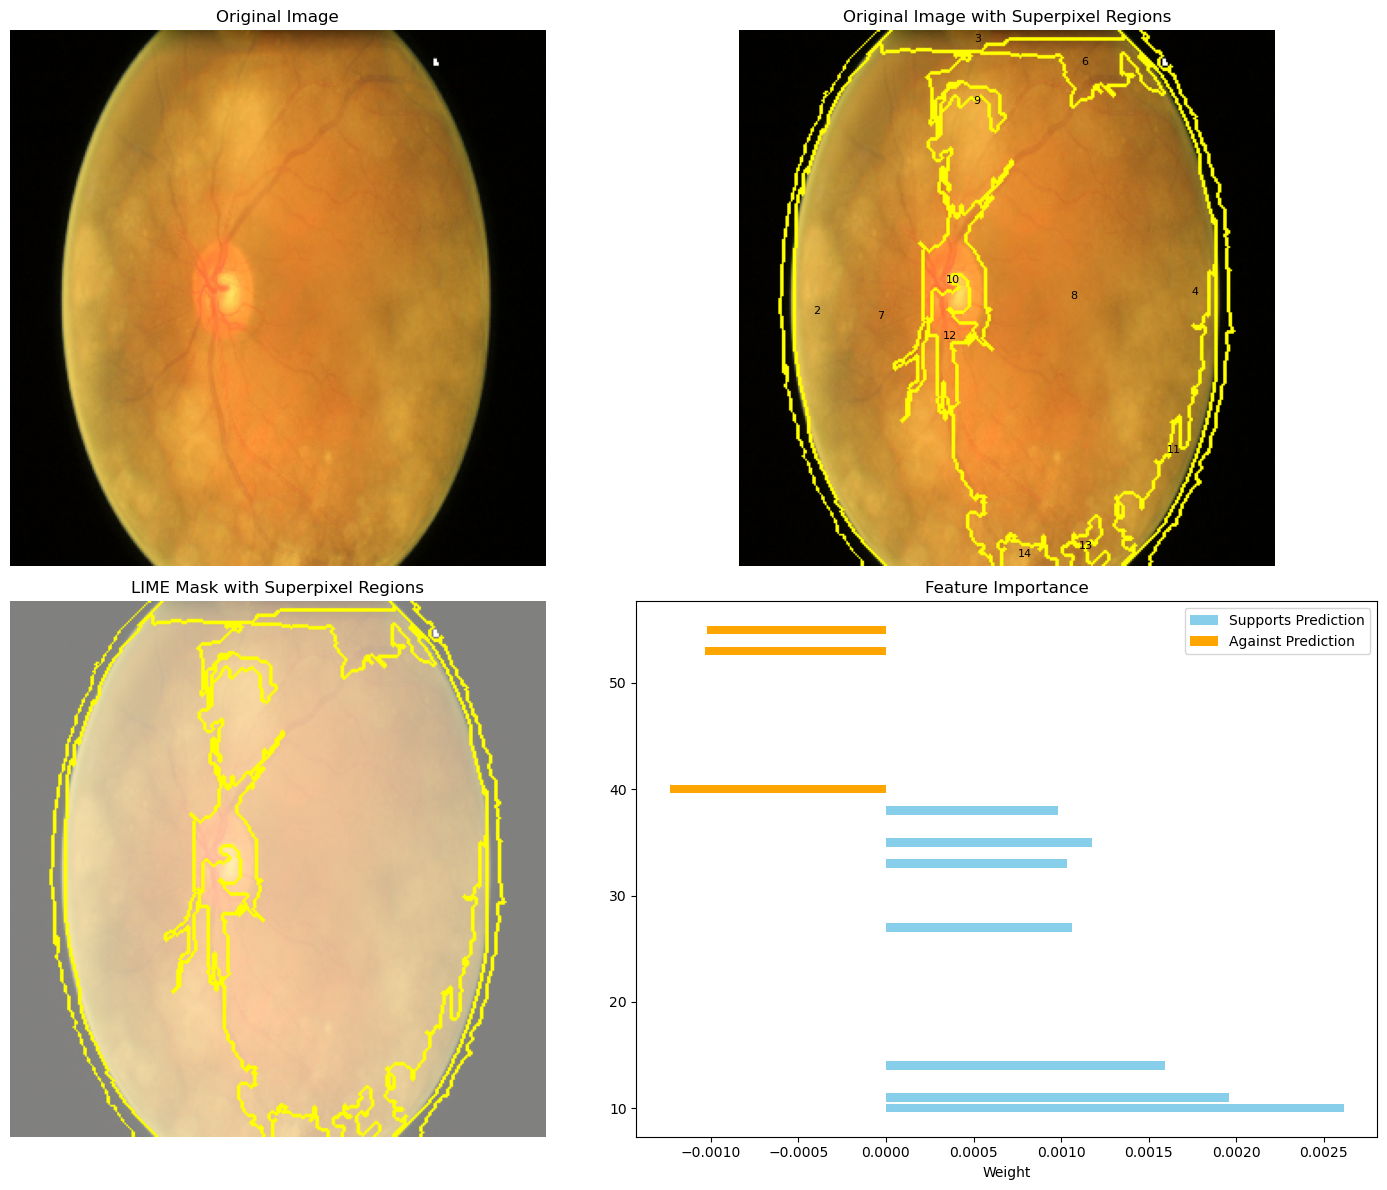

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, mark_boundaries
from lime import lime_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing test images
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

# Define batch size
BATCH_SIZE = 8

# Define image dimensions
HEIGHT = 300
WIDTH = 300

# Define number of desired superpixels
NUM_SUPERPIXELS = 300

# Define scale parameter for Felzenszwalb segmentation
SCALE = 100

# Define sigma parameter for Felzenszwalb segmentation
SIGMA = 0.8

def generate_superpixels(image, num_superpixels):
    # Perform Felzenszwalb segmentation
    segments_fz = felzenszwalb(image, scale=SCALE, sigma=SIGMA, min_size=num_superpixels)
    # Mark the boundaries of the superpixels
    superpixel_boundaries = mark_boundaries(image, segments_fz)
    return superpixel_boundaries, segments_fz

def generate_outputs(image, model):
    # Generate superpixels
    superpixel_boundaries, segments_fz = generate_superpixels(image, NUM_SUPERPIXELS)

    # Explain the model's prediction for the chosen image
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

    # Display the LIME mask with color representation and labels
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False, min_weight=0.1)

    plt.figure(figsize=(15, 12))  # Adjust the figure size as needed

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Original Image with Superpixel Boundaries
    plt.subplot(2, 2, 2)
    plt.imshow(superpixel_boundaries)
    for idx, num in enumerate(np.unique(segments_fz), start=1):
        if num == 0:
            continue  # Skip background label
        label_mask = segments_fz == num
        label_center = np.mean(np.argwhere(label_mask), axis=0)
        plt.text(label_center[1], label_center[0], str(idx), color='black', fontsize=8, ha='center', va='center')
    plt.title('Original Image with Superpixel Regions')
    plt.axis('off')

    # Lime Mask with Superpixel Regions
    plt.subplot(2, 2, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, segments_fz))
    plt.title('LIME Mask with Superpixel Regions')
    plt.axis('off')

    # Feature Importance Graph
    top_features = [str(f[0]) if isinstance(f[0], int) else f[0] for f in explanation.local_exp[explanation.top_labels[0]][:10]]
    top_weights = [f[1] for f in explanation.local_exp[explanation.top_labels[0]][:10]]
    plt.subplot(2, 2, 4)

    # Separate positive and negative features
    positive_features = [feature for feature, weight in zip(top_features, top_weights) if weight > 0]
    positive_weights = [weight for weight in top_weights if weight > 0]
    negative_features = [feature for feature, weight in zip(top_features, top_weights) if weight < 0]
    negative_weights = [weight for weight in top_weights if weight < 0]

    # Plot the positive and negative weights with color differentiation
    plt.barh(positive_features, positive_weights, color='skyblue', align='center', label='Supports Prediction')
    plt.barh(negative_features, negative_weights, color='orange', align='center', label='Against Prediction')

    plt.xlabel('Weight')
    plt.title('Feature Importance')
    plt.legend()
    plt.tight_layout()

    # Show the plots
    plt.show()

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Reset the generator to ensure consistent behavior
test_generator.reset()

# Retrieve a batch of images from the test generator
test_batch = next(test_generator)

# Choose a specific image index from the batch
image_index_to_process = 0  # Change this to select a different image
image = test_batch[image_index_to_process]  # Retrieve the image from the batch

# Assuming you have a model named 'model'
# Generate outputs using LIME and Felzenszwalb superpixels
generate_outputs(image, model)



In [3]:
pip install shap



  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/39/6c/4ab39615fc3ffe40faaa62fc2feb43868b8ce946c671e84bf476c1e06116/shap-0.45.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.7 from https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/453.1 kB ? eta -:--:--
   -- ------------------------------------- 30.7/453.1 kB 1.4 MB/s eta 0:00:01
   ----- --------------------------------- 61.4/453.1 kB 825.8 kB/s eta 0:00:01
   --------- ---------------------------- 112.6/453.1 kB 819.2 kB/s eta 0:00:01
   ------------ ------------------------- 143.4/453.1 kB 853.3 kB/s eta 0:00:01
   ------------ ------------------------- 153.6/453.1 kB 833.5 kB/s eta 0:00:01
   ------------------ ------------------- 225.3/453.1 kB 811.5 kB/s eta 0:00:01
   ------------------------ ------------- 

In [1]:
import shap

In [3]:
import tensorflow as tf


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
Epoch 1/2


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.5410 - loss: 1.8577 - val_accuracy: 0.7385 - val_loss: 0.5843
Epoch 2/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.7281 - loss: 0.6252 - val_accuracy: 0.7385 - val_loss: 0.5796


17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7732 - loss: 0.5800
Test Loss: 0.6024088263511658
Test Accuracy: 0.7384615540504456
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Confusion Matrix:
[[96  0]
 [34  0]]
Classification Report:
              precision    recall  f1-score   support

     class_1       0.74      1.00      0.85        96
     class_2       0.00      0.00      0.00        34

    accuracy                           0.74       130
   macro avg       0.37      0.50      0.42       130
weighted avg       0.55      0.74      0.63       130



C:\Users\yamun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


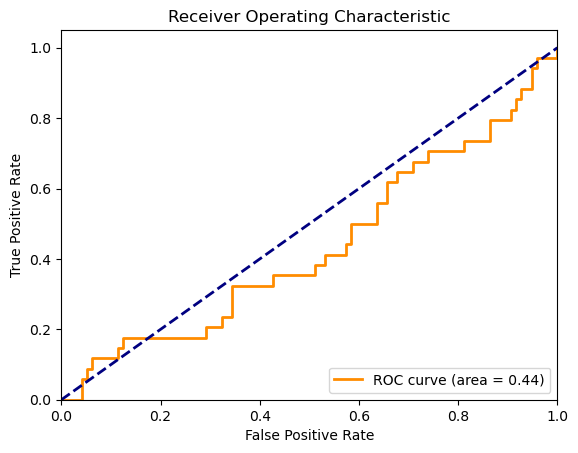

In [5]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

# Define directories
TRAIN_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

# Define constants
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
NUM_EPOCHS = 2

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_list), activation='softmax'))

# Compile the model
adam = Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=90,
                                  horizontal_flip=True,
                                  vertical_flip=False)

# Create data generators
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE)

# Train the model
history = model.fit(x=train_generator, epochs=NUM_EPOCHS, steps_per_epoch=15,
                    shuffle=True, validation_data=test_generator)
model.save("lenet_model.h5")

# Evaluate the model
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])
test_generator.reset() 

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_list)
print("Classification Report:")
print(report)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])  
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


C:\Users\yamun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Found 130 images belonging to 2 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

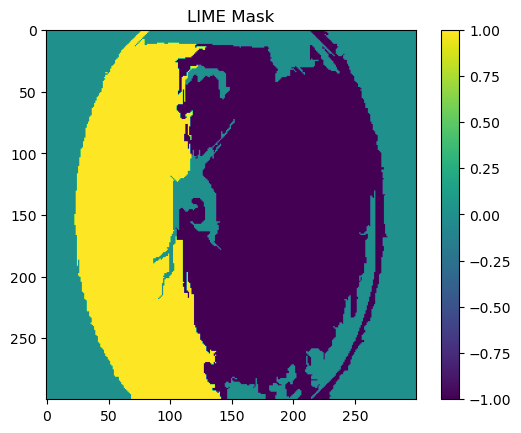

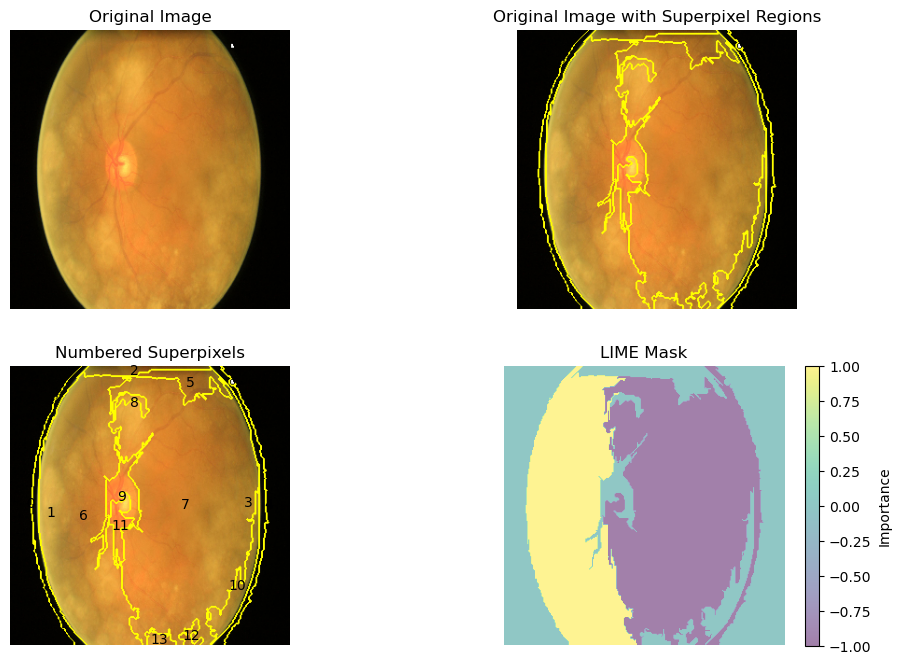

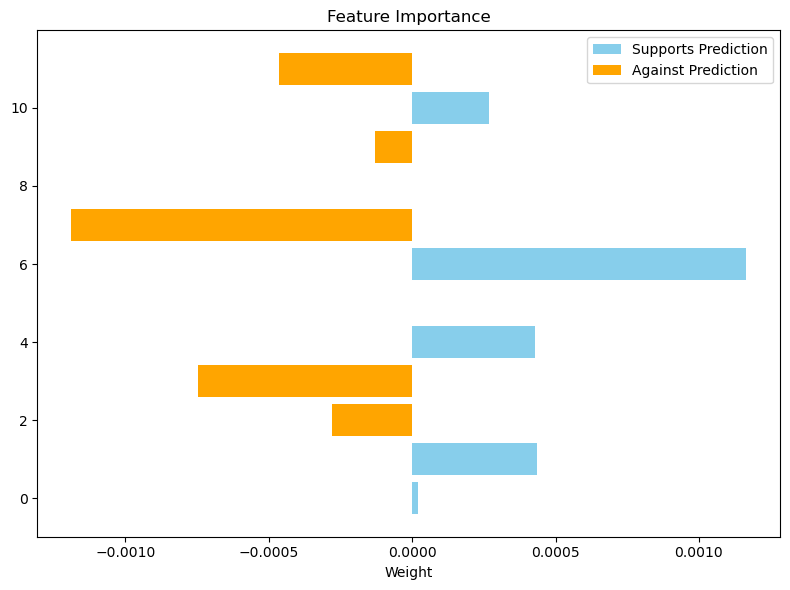

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, mark_boundaries
from lime import lime_image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing test images
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

# Define batch size
BATCH_SIZE = 8

# Define image dimensions
HEIGHT = 300
WIDTH = 300

# Define number of desired superpixels
NUM_SUPERPIXELS = 300

# Define scale parameter for Felzenszwalb segmentation
SCALE = 100

# Define sigma parameter for Felzenszwalb segmentation
SIGMA = 0.8

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Example for binary classification, adjust output units and activation accordingly
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Example for binary classification, adjust loss function accordingly
              metrics=['accuracy'])

def generate_superpixels(image, num_superpixels):
    # Perform Felzenszwalb segmentation
    segments_fz = felzenszwalb(image, scale=SCALE, sigma=SIGMA, min_size=num_superpixels)
    # Mark the boundaries of the superpixels
    superpixel_boundaries = mark_boundaries(image, segments_fz)
    return superpixel_boundaries, segments_fz

def generate_lime_mask(image, model, segments_fz):
    try:
        # Mask out the background (assuming the background is black)
        image_gray = np.mean(image, axis=2)
        background_mask = (image_gray == 0)

        # Apply background mask to the image
        masked_image = np.copy(image)
        masked_image[background_mask] = 0  # Set background pixels to black
        
        # Explain the model's prediction for the masked image
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(masked_image, model.predict, top_labels=1, segmentation_fn=lambda img: segments_fz)

        # Get the Lime mask
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

        # Apply the background mask to the Lime mask
        mask[background_mask] = 0

        return mask, explanation
    except Exception as e:
        print("Error generating Lime mask:", e)
        return None, None

def generate_outputs(image, model):
    # Generate superpixels using Felzenszwalb segmentation
    superpixel_boundaries, segments_fz = generate_superpixels(image, NUM_SUPERPIXELS)

    # Generate Lime mask based on superpixels
    lime_mask, explanation = generate_lime_mask(image, model, segments_fz)

    if lime_mask is None:
        print("Failed to generate Lime mask. Skipping output generation.")
        return

    # Verify Lime mask
    print("Lime mask:", lime_mask)
    plt.imshow(lime_mask, cmap='viridis')
    plt.title("LIME Mask")
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Original Image with Superpixel Boundaries
    plt.subplot(2, 2, 2)
    plt.imshow(superpixel_boundaries)
    plt.title('Original Image with Superpixel Regions')
    plt.axis('off')

    # Numbered Superpixels
    plt.subplot(2, 2, 3)
    plt.imshow(superpixel_boundaries)
    for (i, segVal) in enumerate(np.unique(segments_fz)):
        # construct a mask for the segment
        segMask = np.zeros(image.shape[:2], dtype="uint8")
        segMask[segments_fz == segVal] = 255
        plt.text(np.mean(np.where(segments_fz == segVal)[1]),
                 np.mean(np.where(segments_fz == segVal)[0]),
                 str(i), color="black", fontsize=10, ha="center", va="center")
    plt.title('Numbered Superpixels')
    plt.axis('off')

    # Lime Mask
    plt.subplot(2, 2, 4)
    cmap = 'viridis'
    mask_image = plt.imshow(lime_mask, cmap=cmap, alpha=0.5)
    plt.title("LIME Mask")
    colorbar = plt.colorbar(mask_image)
    colorbar.set_label('Importance')
    plt.axis('off')

    # Generate feature importance graph
    if explanation:
        top_features = [str(f[0]) if isinstance(f[0], int) else f[0] for f in explanation.local_exp[explanation.top_labels[0]][:10]]
        top_weights = [f[1] for f in explanation.local_exp[explanation.top_labels[0]][:10]]

        # Separate positive and negative features
        positive_features = [feature for feature, weight in zip(top_features, top_weights) if weight > 0]
        positive_weights = [weight for weight in top_weights if weight > 0]
        negative_features = [feature for feature, weight in zip(top_features, top_weights) if weight < 0]
        negative_weights = [weight for weight in top_weights if weight < 0]

        # Plot the positive and negative weights with color differentiation
        plt.figure(figsize=(8, 6))
        plt.barh(positive_features, positive_weights, color='skyblue', align='center', label='Supports Prediction')
        plt.barh(negative_features, negative_weights, color='orange', align='center', label='Against Prediction')
        plt.xlabel('Weight')
        plt.title('Feature Importance')
        plt.legend()
        plt.tight_layout()

    # Show the plots
    plt.show()

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Reset the generator to ensure consistent behavior
test_generator.reset()

# Retrieve a batch of images from the test generator
test_batch = next(test_generator)

# Choose a specific image index from the batch
image_index_to_process = 0  # Change this to select a different image
image = test_batch[image_index_to_process]  # Retrieve the image from the batch

# Assuming you have a model named 'model'
# Generate outputs using LIME and Felzenszwalb superpixels
generate_outputs(image, model)
